# Évolution du nonbre de nouvelles contaminations et de nouveaux cas actifs de Covid-19 en France
Le but de ce notebook est de faire un point sur le nombre de nouveaux cas actifs et de nouvelles contamination en France, depuis le début du confinement puis en zoomant sur le dernier mois, d'abord globalement puis par démographie.

## Méthodologie
Ici on se base sur le nombre de nouvelles hospitalions de [sources officielles](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/#_). À partir de là, on estime le nombre de nouvelles hospitalisations par démographie (sexe et tranche d'âge). Puis, en se basant sur les probabilités de transitions entre les différents stades de la maladie pour chaque démographie ("Estimating the burden of SARS-CoV-2 in France", [Salje et al.](https://hal-pasteur.archives-ouvertes.fr/pasteur-02548181)) et ces durées de transition (estimées par calibration de [CAST](https://towardsdatascience.com/cast-model-for-epidemics-simulation-6091f70b7fc4) on en déduit a posteriori la nombre de nouveaux cas actifs et de nouvelles contaminations. Cette méthode est implémentée [ici](../propagsim/actual_state_estimation.py).Vu les décalages entre la contamination et l'activation d'un cas puis l'hospitalisation, les estimations suivantes ne vont que jusqu'à 12 jours avant le jour courant.

Compte-tenu des durées de transition, *ces estimations ne vont que jusqu'à 13 jours avant la date actuelles*.

In [1]:
import os, re
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator

data_path = os.path.join('..', 'data')

f_regexp = r'^state_estimation_til_\d{4}-\d{2}-\d{2}.csv$'
files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and re.match(f_regexp, f)]

d_regexp = re.compile('\d{4}-\d{2}-\d{2}')
dates = [d_regexp.search(f).group(0) for f in files]
date = max([datetime.strptime(date, '%Y-%m-%d') for date in dates]).strftime('%Y-%m-%d')

filepath = os.path.join(data_path, f'state_estimation_til_{date}.csv')
df = pd.read_csv(filepath)
df['asymptomatic'] /= 5
df['day'] = pd.to_datetime(df['day'], format='%Y-%m-%d')
df = df.rename(columns={'asymptomatic': 'new_contaminations', 'infected': 'new_active_cases'})

## Analyse globale
Ici on regarde l'évolution totale, sans distinction par démographie.

In [2]:
df_day = df.groupby(['day'])[['new_contaminations', 'new_active_cases']].agg('sum').reset_index()
date_format = '%d/%m/%Y'

In [3]:
def plt_total(df_day):
    min_date, max_date = df_day['day'].min().strftime(date_format), df_day['day'].max().strftime(date_format)
    fig, ax = plt.subplots(figsize=(12, 12))

    # Add x-axis and y-axis
    ax.plot(df_day['day'].values, df_day['new_contaminations'], color='purple', label='nouvelles contaminations')
    ax.plot(df_day['day'].values, df_day['new_active_cases'], color='red', label='nouveaux cas actifs')

    # Set title and labels for axes
    ax.set_xlabel('Date', fontsize=15)
    ax.set_ylabel('Nouveaux cas', fontsize=15)
    ax.set_title(f'Nombre total de nouveaux cas et de nouvelles contaminations de Covid-19 en France\ndu {min_date} au {max_date}', fontsize=20)

    # Define the date format
    date_form = DateFormatter('%d/%m')
    ax.xaxis.set_major_formatter(date_form)

    # Ensure a major tick for each week using (interval=1) 
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))

    ax.set_ylim((0, df_day['new_contaminations'].max()))
    ax.legend(frameon=False)

    plt.show()

### Depuis le début du confinement

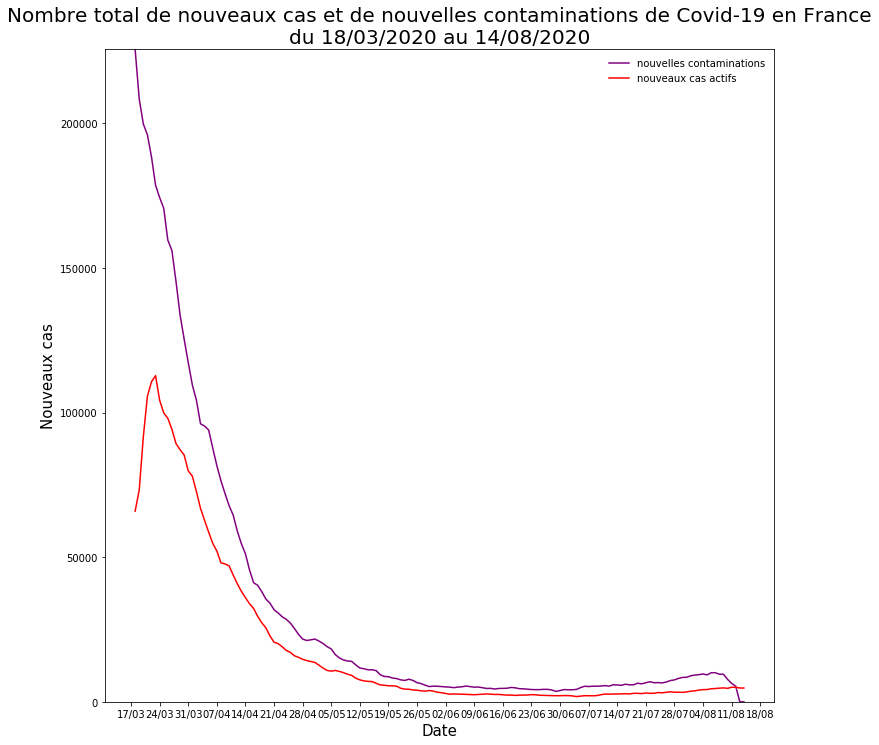

In [4]:
plt_total(df_day)

Le nombre de nouveaux cas actifs a commencé à fortement baisser environ une semaine après le début du confinement. Le nombre de contaminations quant à lui était déjà en forte baisse dês le début du confinement.
Ces nombres de nouveaux cas continuent à baisser jusqu'à fin main / début juin avant de connaître un petit sursaut puis une légère hausse à partir de début juillet.

In [5]:
def find_min(colname, df_day):
    min_cases = df_day[colname].min()
    day_min_cases = df_day[df_day[colname] == min_cases]['day'].max()

    print(f"It\'s on {day_min_cases.strftime('%Y-%m-%d')} that the number of Covid-19 {colname} was minimal, reaching {int(min_cases)} cases")

    max_cases_after_min = df_day.loc[df_day['day'] >= day_min_cases,:][colname].max()
    day_max_cases_after_min = df_day[(df_day['day'] >= day_min_cases) & (df_day[colname] == max_cases_after_min)]['day'].max()

    print(f"It\'s on {day_max_cases_after_min.strftime('%Y-%m-%d')} that {colname} of Covid-19 cases reached again a maximum, reaching {int(max_cases_after_min)} cases")

In [6]:
find_min('new_contaminations', df_day)
print()
find_min('new_active_cases', df_day)

It's on 2020-08-14 that the number of Covid-19 new_contaminations was minimal, reaching 0 cases
It's on 2020-08-14 that new_contaminations of Covid-19 cases reached again a maximum, reaching 0 cases

It's on 2020-07-04 that the number of Covid-19 new_active_cases was minimal, reaching 1802 cases
It's on 2020-08-12 that new_active_cases of Covid-19 cases reached again a maximum, reaching 5029 cases


C'est le 29 juin que le nombre de nouvelles contaminations a été le plus faible. Le 4 août il a connu un nouveau pic avant de redescendre. Quant au nombre de nouveaux cas actifs, il était encore en hausse le 8 août. La baisse du nombre de contaminations ne s'y était pas encore répercutée.

### Zoom sur le dernier mois

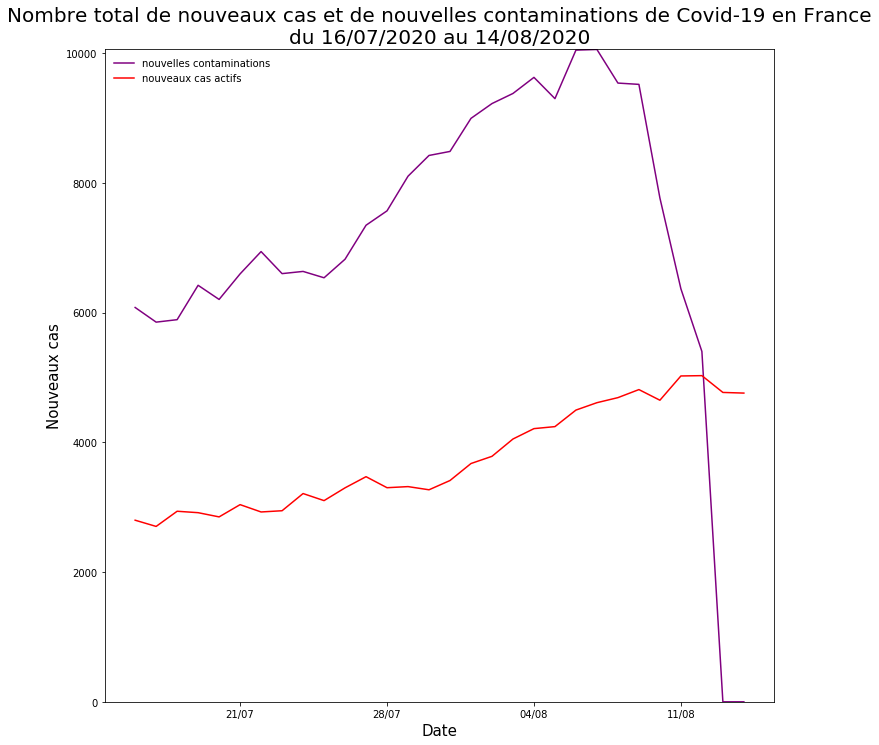

In [7]:
df_day_last = df_day.tail(30)

plt_total(df_day_last)

## Analyse par démographie
Ici nous allons analyser le nobres de nouvelles contaminations et nouveaux cas actifs par sexe et tranche d'âge

In [8]:
def map_demography(demography):
    gender, age = demography.split('_')
    if age == '0':
        age = '0-19'
    elif age == '80':
        age = '80+'
    else:
        age = f'{age}-{int(age)+9}'
    return f'{gender} {age}'


def plot_by_demography(df, col):
    min_date, max_date = df_day['day'].min().strftime(date_format), df_day['day'].max().strftime(date_format)
    fig, ax = plt.subplots(figsize=(12, 12))
    demographies = df['demography'].unique().tolist()
    cmap = plt.cm.get_cmap('coolwarm', len(demographies))
    for i, demography in enumerate(demographies):
        df_dem = df.loc[df['demography'] == demography,:]
        ax.plot(df_dem['day'].values, df_dem[col].values, color=cmap(i), label=map_demography(demography))
 
    name_dic = {'new_contaminations': 'Nouvelles Contaminations', 'new_active_cases': 'Nouveaux Cas Actifs'}
    name = name_dic.get(col)
    ax.set_xlabel('Date', fontsize=15)
    ax.set_ylabel(name, fontsize=15)
    ax.set_title(f'Nombre total de {name} de Covid-19 en France par Démographie\ndu {min_date} au {max_date}', fontsize=20)

    # Define the date format
    date_form = DateFormatter('%d-%m')
    ax.xaxis.set_major_formatter(date_form)

    # Ensure a major tick for each week using (interval=1) 
    ax.xaxis.set_major_locator(WeekdayLocator(interval=1))

    ylim = (0, df[col].max())
    ax.set_ylim(ylim)
    ax.legend(frameon=False)

    plt.show()

### Depuis le début du confinement
D'abord le nombre de nouvelles contaminations:

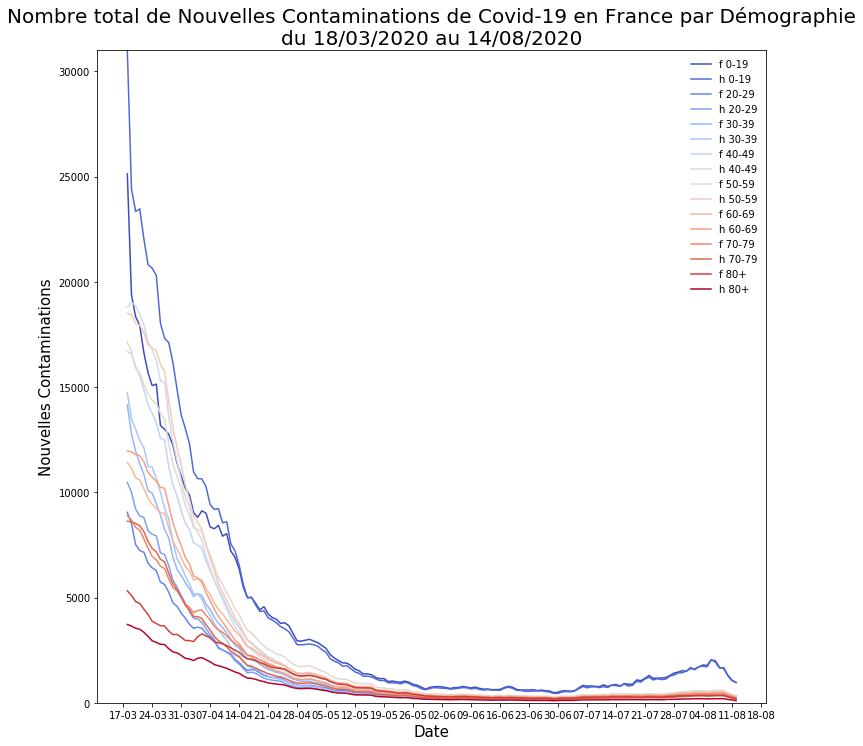

In [9]:
plot_by_demography(df, 'new_contaminations')

Puis le nombre de nouveaux cas actifs:

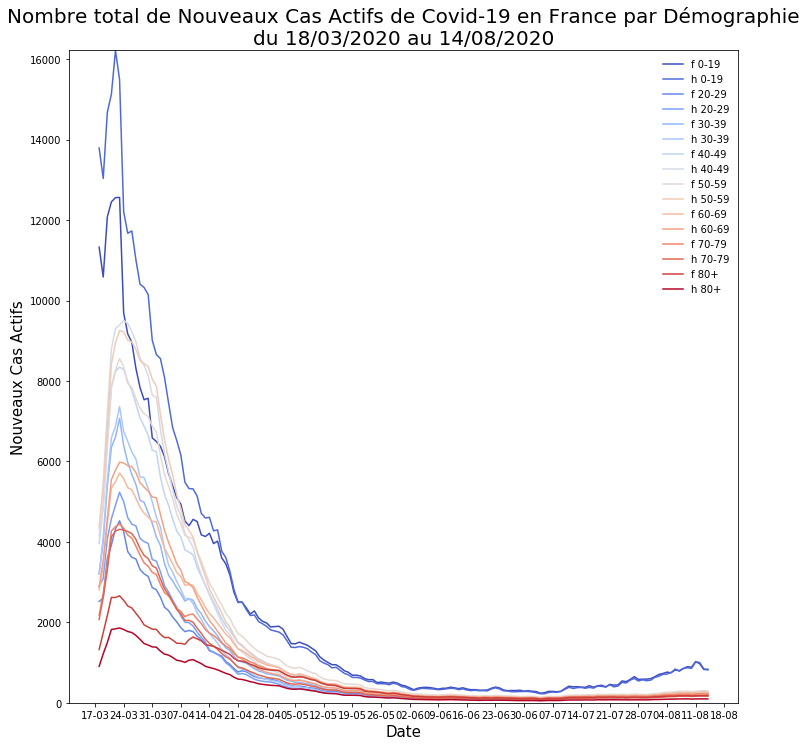

In [10]:
plot_by_demography(df, 'new_active_cases')

Le nombre de cas actifs a commencé à baisser très fortement environ une semaine après le début du confinement pour toutes les démographies. Il a continué à baisser jusqu'à début juin avant de se stabiliser pendant plus d'un mois avant de repartir légềrement à la hausse.

### Zoom sur le dernier mois

In [11]:
max_day = df_day['day'].max()
min_day = max_day - timedelta(days=30)

df_last = df.loc[df['day'] >= min_day]

D'abord le nombre de nouvelles contaminations:

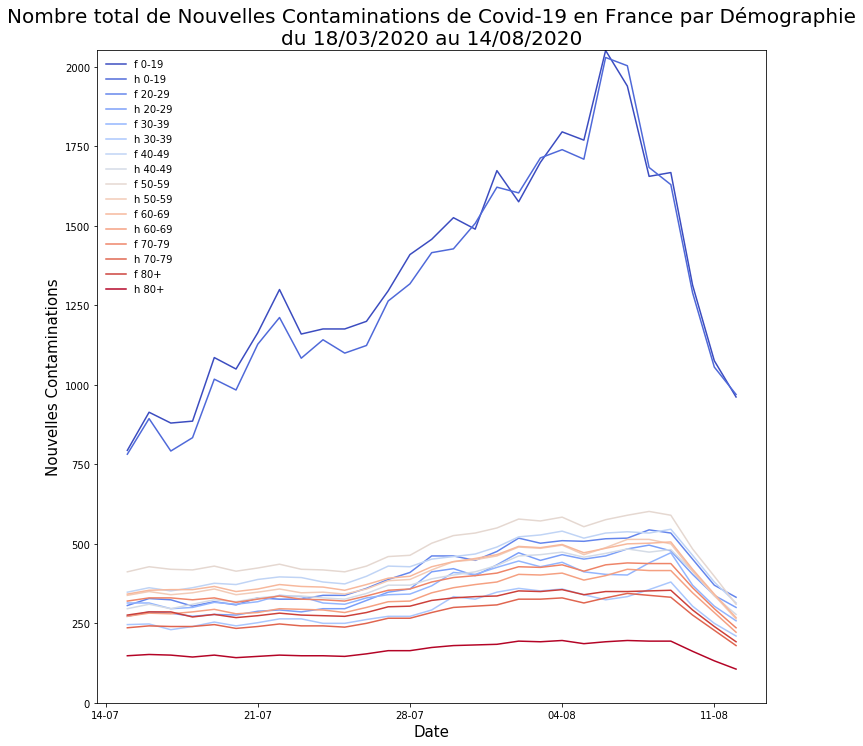

In [12]:
plot_by_demography(df_last, 'new_contaminations')

Puis le nombre de nouveaux cas actifs:

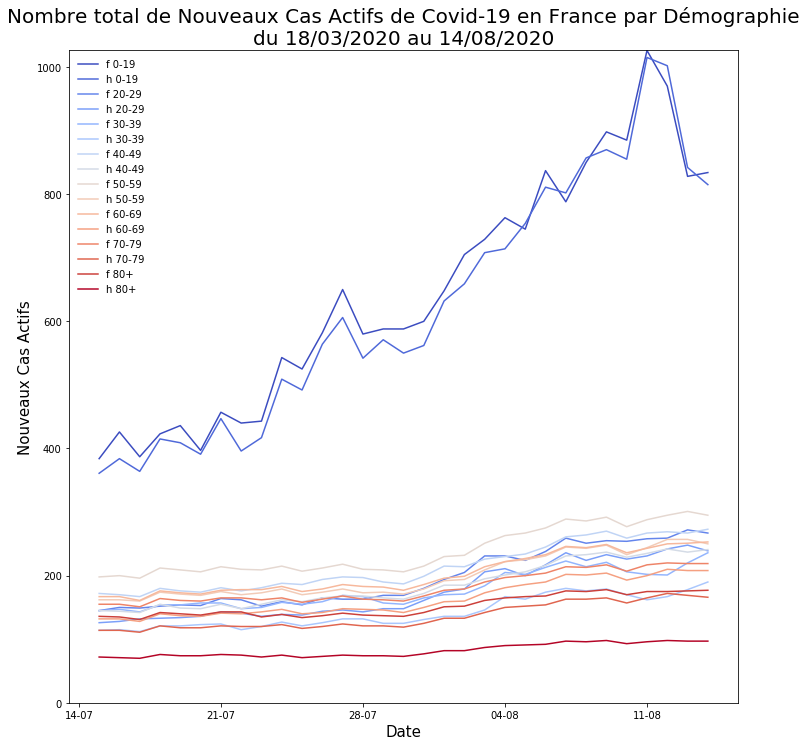

In [13]:
plot_by_demography(df_last, 'new_active_cases')

C'est chez les plus jeunes que l'augmentation des cas actifs est la plus fortes, triplant presque durant le dernier mois (+200%). Chez les autres démographies, l'augmentation durant cette période est plus faible, aux alentours de +50%.

Entre le 1er et le 4 août, le nombre de nouvelles contaminations a commencé à baissé pour toutes les démographies.

## Conclusion
Il semblerait que la remontée qu'on observe actuellement soit due à une remontée des contaminations fin juillet dont on subit les contrecoups avec un décalage temporelle, explicant la recrudescence actuelle des hospitalisations etc. Toutefois il semblerait que début août le nombre de contamination ait recommencé à fortement baisser. La recrudescence observée actuellement ne devrait donc être que passagère.

## Annexe: âge moyen des nouvelles contaminations
pour chaque démographie, on prend l'âge intermédiaire, par exemple 25 ans pour 20-29, sauf pour les moins de 20 ans où on prend 18 ans et les 80+ ans où on prend 85 ans

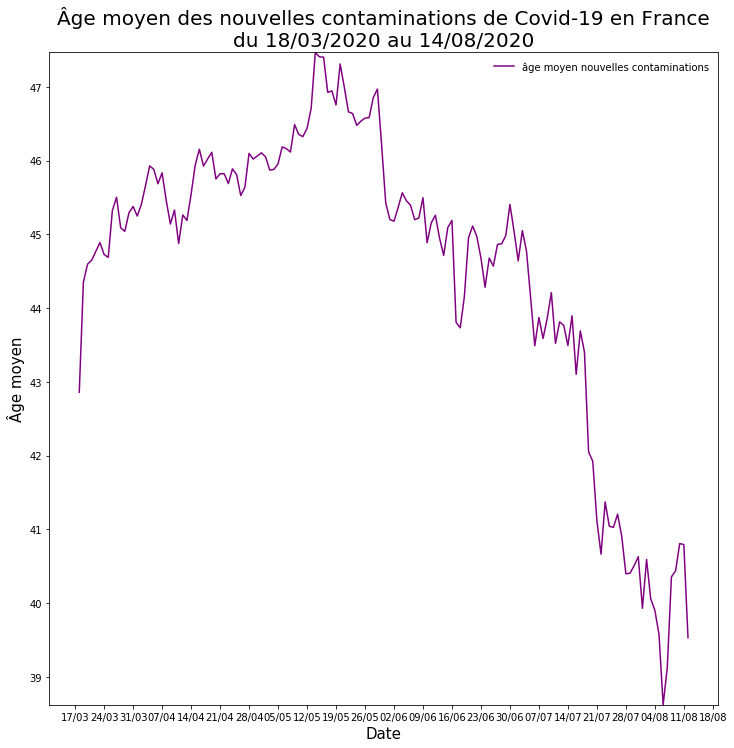

In [14]:
def age_demography(demography):
    age = int(demography.split('_')[1]) + 5
    age = age if age != 5 else 18
    return age


df['avg_age'] = df['demography'].apply(lambda x: age_demography(x))
df['new_contaminations_age'] = df['new_contaminations'] * df['avg_age']

df_day = df.groupby(['day'])[['new_contaminations', 'new_contaminations_age']].agg('sum').reset_index()

df_day['avg_age_contamination'] = df_day['new_contaminations_age'] / df_day['new_contaminations']


fig, ax = plt.subplots(figsize=(12, 12))

min_date, max_date = df_day['day'].min().strftime(date_format), df_day['day'].max().strftime(date_format)

# Add x-axis and y-axis
ax.plot(df_day['day'].values, df_day['avg_age_contamination'], color='purple', label='âge moyen nouvelles contaminations')

# Set title and labels for axes
ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Âge moyen', fontsize=15)
ax.set_title(f'Âge moyen des nouvelles contaminations de Covid-19 en France\ndu {min_date} au {max_date}', fontsize=20)

# Define the date format
date_form = DateFormatter('%d/%m')
ax.xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=1) 
ax.xaxis.set_major_locator(WeekdayLocator(interval=1))

ax.set_ylim((df_day['avg_age_contamination'].min(), df_day['avg_age_contamination'].max()))
ax.legend(frameon=False)

plt.show()